In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from functions import *

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import SGDRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

In [3]:
import statsmodels.api as sm
from statsmodels.stats import diagnostic

# 3. Model error

Another point we may want to look into is the distribution of the model errors, i.e. the $\varepsilon$ from the regression model.

In [4]:
#Model import
model = joblib.load('model.joblib')

In [5]:
#Data import
diam_data = pd.read_csv('diamonds.csv', index_col = 0)

In [6]:
#Data split
y = np.divide(diam_data['price'], diam_data['carat'])
X = diam_data.drop(columns=['price'])
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=50)

In [7]:
#Obtaining predicted values
y_train_pred = model.predict(X_train)
#Log-transforming, as the model is fit on the log of the values
y_train_pred_log = np.log(y_train_pred)
y_train_log = np.log(y_train)

In [8]:
#Compute error
training_epsilon = y_train_log - y_train_pred_log

## 3.1. Model prediction error distribution

Ideally, we want the model prediction error to be close to a gaussian, which would allow us to apply statistical techniques to estimate the prediction error and interval, by either estimating both the mean and variance, or only the variance and assuming the mean is 0.

We first visualize the raw prediction error values.

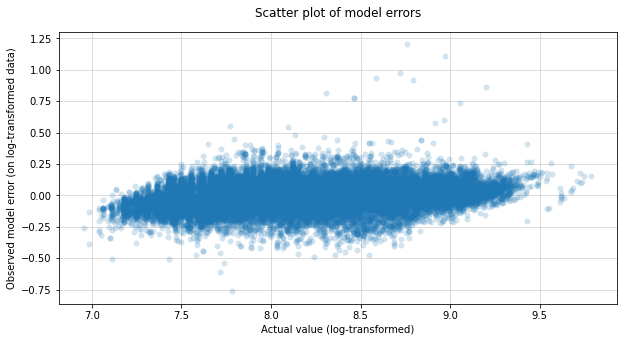

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(
    x=y_train_log,
    y=training_epsilon,
    alpha=.2,
    linewidth=0,
    ax=ax
)

ax.set_title('Scatter plot of model errors', pad=15)
ax.set_ylabel('Observed model error (on log-transformed data)')
ax.set_xlabel('Actual value (log-transformed)')

ax.grid(True, axis='both', color='lightgrey')
ax.set_axisbelow(True)

plt.show()

At first glance, we can spot no immediate pattern in the error data, which tends to support a fairly random distribution across our dataset.

In [10]:
from scipy import stats

We can also visualize the empirical distribution of our data, compared to the theoretical normal distribution.

In [11]:
#Compute normal distribution with same parameters
x_norm = np.linspace(
    start=training_epsilon.min(),
    stop=training_epsilon.max(),
    num=len(training_epsilon))

norm_epsilon = stats.norm(
    loc=training_epsilon.mean(), #Sample mean
    scale=training_epsilon.std(ddof=1), #Unbiased standard deviation (standard error))
).pdf(x_norm)

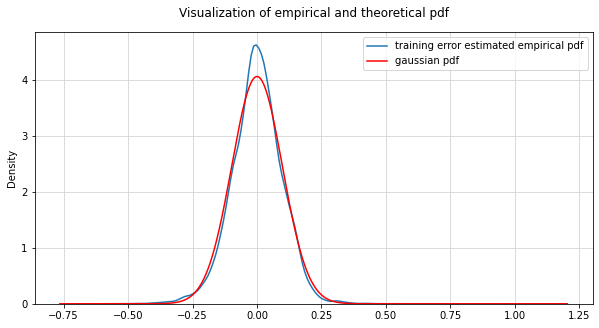

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

#Plot error
sns.kdeplot(x=training_epsilon,
            ax=ax,
            label='training error estimated empirical pdf',
            cut=0)

#Plot theoretical normal distribution
ax.plot(x_norm,
        norm_epsilon,
        color='r',
        label='gaussian pdf')

ax.set_title("Visualization of empirical and theoretical pdf", pad=15)

ax.grid(True, axis='both', color='lightgrey')
ax.set_axisbelow(True)

ax.legend()

plt.show()

At first glance, one can notice that our data is more concentrated around 0 than the normal distribution with similar parameters (mean and standard deviation).

We can also look at the qq plot.

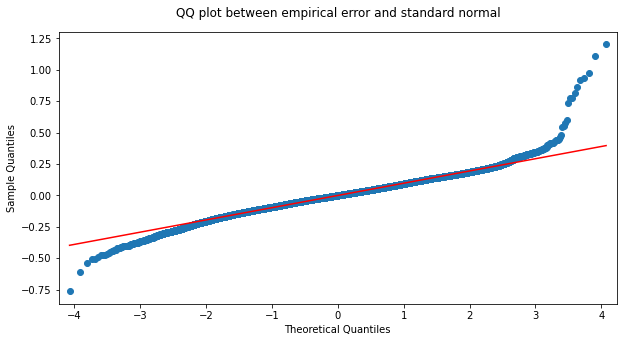

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

sm.qqplot(training_epsilon, line='r', ax=ax)
ax.set_title("QQ plot between empirical error and standard normal", pad=15)

plt.show()

The qq plot seems to confirm that the observed distribution of the model errors does not follow a gaussian distribution, and seems to have heavier tails.

Finally, we can try to confirm this through a Kolmogorov-Lilliefors goodness of fit test.

In [14]:
kl_test = diagnostic.lilliefors(training_epsilon, dist='norm')

In [15]:
print(f"Based on the KL test, we get a p-value for the normal distribution hypothesis of {kl_test[1]:.3f}.")

Based on the KL test, we get a p-value for the normal distribution hypothesis of 0.001.


With this test, we can reject the normal distribution hypothesis with a level of 0.995, making this a highly unlikely hypothesis with our data.

Unfortunately, our analysis of the errors heavily discredit the normal distribution hypothesis, which we would have like to use to get prediction intervals. Due to the heavy tails on both ends of the distribution, the normal distribution does not constitute a maximizer for the possible absolute error. By continuing to use the current algorithms, we have to forego using prediction intervals, and keep focusing on the predicted expected value.

## 3.2. Modelling the prediction interval

Since we can't use simple statistical inference to estimate a prediction interval, with a non-normal prediction error, we will rely on an alternative approach: modelling the distribution quantiles.

This solution can be done with boosting regression trees algorithms, such as LightGBM that we are using here. We will use the same hyperparameters to model the $\alpha$ and $1-\alpha$ quantiles of our distribution, for a given level $\alpha$. We suggest using a 95% confidence interval, i.e. $\alpha = 0.025$.

In [16]:
alpha = 0.025

We start by cloning the model we are using for the prediction, and adapt the hyperparameters to fit our purpose. We then proceed by training the model on the training set.

In [17]:
from sklearn.base import clone

In [18]:
q1_model = clone(model.best_estimator_)
q2_model = clone(model.best_estimator_)

In [19]:
q1_model.set_params(**{
    'regressor__model__objective': 'quantile',
    'regressor__model__alpha': alpha
})

q2_model.set_params(**{
    'regressor__model__objective': 'quantile',
    'regressor__model__alpha': 1-alpha
})

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('prep_imputer',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        IterativeImputer(missing_values=0,
                                                                                                                         random_state=50)),
                                                                                                       ('preprocess_imputer',
                                                                                                        ColumnTransformer(transformers=[('discretizer',
                                                                                                                                         CustomBinDiscretizer(bins=[0,
                                                                                                                                                                    0.5,
                                                                                                                                                                    0.75,
                                                                                                                                                                    1,
                                                                                                                                                                    1.5,
                                                                                                                                                                    2,
                                                                                                                                                                    inf],
                                                                                                                                                              labels=False),
                                                                                                                                         [0]),
                                                                                                                                        ('passthrough',
                                                                                                                                         'passthrough',
                                                                                                                                         [1])]))]),
                                                                                       ['carat',
                                                                                        'x']),
                                                                                      ('or_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['cut',
                                                                                        'color',
                                                                                        'clarity']),
                                                                                      ('passthrough',
                                                                                       'passthrough',
                                                                                       ['depth',
                                                                                        'table'])])),
                                         

In [20]:
q1_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('prep_imputer',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        IterativeImputer(missing_values=0,
                                                                                                                         random_state=50)),
                                                                                                       ('preprocess_imputer',
                                                                                                        ColumnTransformer(transformers=[('discretizer',
                                                                                                                                         CustomBinDiscretizer(bins=[0,
                                                                                                                                                                    0.5,
                                                                                                                                                                    0.75,
                                                                                                                                                                    1,
                                                                                                                                                                    1.5,
                                                                                                                                                                    2,
                                                                                                                                                                    inf],
                                                                                                                                                              labels=False),
                                                                                                                                         [0]),
                                                                                                                                        ('passthrough',
                                                                                                                                         'passthrough',
                                                                                                                                         [1])]))]),
                                                                                       ['carat',
                                                                                        'x']),
                                                                                      ('or_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['cut',
                                                                                        'color',
                                                                                        'clarity']),
                                                                                      ('passthrough',
                                                                                       'passthrough',
                                                                                       ['depth',
                                                                                        'table'])])),
                                         

In [21]:
q2_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('prep_imputer',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        IterativeImputer(missing_values=0,
                                                                                                                         random_state=50)),
                                                                                                       ('preprocess_imputer',
                                                                                                        ColumnTransformer(transformers=[('discretizer',
                                                                                                                                         CustomBinDiscretizer(bins=[0,
                                                                                                                                                                    0.5,
                                                                                                                                                                    0.75,
                                                                                                                                                                    1,
                                                                                                                                                                    1.5,
                                                                                                                                                                    2,
                                                                                                                                                                    inf],
                                                                                                                                                              labels=False),
                                                                                                                                         [0]),
                                                                                                                                        ('passthrough',
                                                                                                                                         'passthrough',
                                                                                                                                         [1])]))]),
                                                                                       ['carat',
                                                                                        'x']),
                                                                                      ('or_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['cut',
                                                                                        'color',
                                                                                        'clarity']),
                                                                                      ('passthrough',
                                                                                       'passthrough',
                                                                                       ['depth',
                                                                                        'table'])])),
                                         

We can check on the test set whether we can expect to capture 95% of the values with these two models.

In [22]:
y_pred_q1 = q1_model.predict(X_test)
y_pred_q2 = q2_model.predict(X_test)

In [23]:
y_test_isbetween = y_test.between(y_pred_q1, y_pred_q2)
y_test_share = y_test_isbetween.sum()/len(y_test)
print(f"The interval between the two models captures {y_test_share:.1%} of the actual values on the test set.")

The interval between the two models captures 94.8% of the actual values on the test set.


We can now do a hypothesis test on this result, with H1 being that we capture $\geq 95\%$ of the values, and H0 being that we capture $< 95\%$ of the values, under a Bernoulli model.

In [24]:
print(f"Our training set has {len(y_test):,d} observations.")

Our training set has 10,788 observations.


Considering the number of observations, we suggest considering asymptotic normality for our test statistic.

We use the test statistic $W = \sqrt{n} \frac{\bar{X}-p}{\sqrt{\bar{X}(1-\bar{X})}}$, with n = number of observations, p = .95 (H0 hypothesis), and $\bar{X}$ being the sample mean. We will compute the asymptotic p-value under the normal assuption that our test statistic is higher than the observed value, $\mathbf{P}(x>W) = 1-\mathbf{P}(x \leq W)$.

In [25]:
p = 0.95
X_hat = y_test_isbetween.mean()
n = len(y_test_isbetween)
W = np.sqrt(n)*(X_hat-p)/np.sqrt(X_hat*(1-X_hat))

In [26]:
pval = 1-stats.norm.cdf(W)

In [27]:
print(f"The p-value under the H0 hypothesis is {pval:.2f}.")

The p-value under the H0 hypothesis is 0.84.


With such a high p-value, one cannot reject the H0 hypothesis: we cannot say we capture 95% of the values. We can however test if we capture 94% of the values, using a similar approach.

In [28]:
p = 0.94
W = np.sqrt(n)*(X_hat-p)/np.sqrt(X_hat*(1-X_hat))

In [29]:
pval = 1-stats.norm.cdf(W)

In [30]:
print(f"The p-value under the H0 hypothesis is {pval:.4f}.")

The p-value under the H0 hypothesis is 0.0001.


This time, the p-value is small enough to asymptotically reject the H0 hypothesis (we do not capture more than 94% of the values with these two models), with a high level of certainty.

We suggest keeping these models, and using the 94% confidence interval.

We can now save the quantile models for future use.

In [31]:
joblib.dump(q1_model, 'q1_model.joblib')
joblib.dump(q2_model, 'q2_model.joblib')

['q2_model.joblib']